In [3]:
# general imports
import numpy as np
import matplotlib.pyplot as plt


from astropy.constants import c
import astropy.units as u
from scipy.ndimage import gaussian_filter1d
# import the main class
from funcs.auroralring import AuroralRing

from scipy.optimize import curve_fit

In [144]:

# inclination of rotation axis in radians with the right convention
i_rot = np.pi/2 - 51.7 * np.pi/180

# inclination of magnetic axis in radians relative to rotation axis
i_mag = 75.5 * np.pi/180

# rotation period in days
P_rot = 3.052 / 24.

# stellar radius in solar radii
R_star = .109

# upper latitude of ring around magnetic axis in radians
PHI_max = 71 * np.pi/180

# lower latitude of ring around magnetic axis in radians
PHI_min = 69 * np.pi/180

# lower latitude must be smaller than upper latitude/
assert PHI_min < PHI_max

In [145]:
# mid latitude of ring around magnetic axis in radians
mid_lat = (PHI_max + PHI_min) / 2

# width of ring around magnetic axis in radians
width = PHI_max - PHI_min

# rotational phase of the star in radians
alpha = np.pi / 3. 


# define the auroral ring
ring = AuroralRing(i_rot=i_rot, i_mag=i_mag, latitude=mid_lat,
                    width=width, Rstar=R_star, P_rot=P_rot, N=60, 
                     gridsize=int(1e4), v_bins=np.linspace(-80, 80, 240))



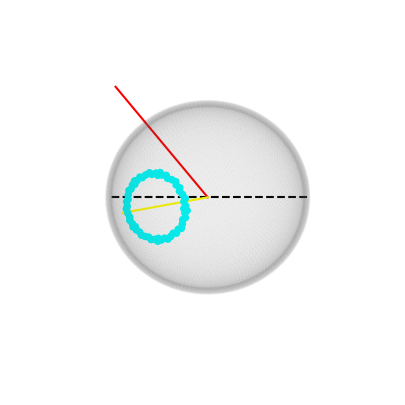

In [146]:
# plot the sphere with the auroral ring
fig, ax = ring.plot_setup_sphere()
ring.get_flux_numerically(alpha=alpha)
ring.plot_sphere_with_auroral_ring(ax, alpha=alpha, sphere_alpha=0.01, ring_alpha=1.)
ring.plot_layout_sphere(ax, view='observer left')

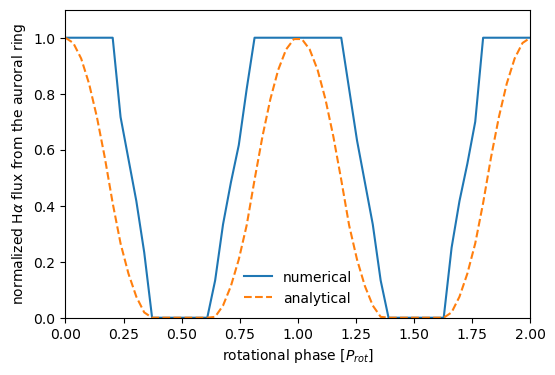

In [147]:
# plot the flux of the auroral ring as a function of rotational phase

# define rotational phases
alphas = np.linspace(0, 4*np.pi, 60)

# calculate the fluxes numerically and analytically
# NOTE: the foreshortening is a geometrical factor that assumes that the Halpha emission is optically thick
# set foreshortening=False to get the optically thin case
int_fluxes = [np.sum(ring.get_flux_numerically(alpha=alpha, normalize=False, foreshortening=False)) 
              for alpha in alphas]
int_fluxes_analytical = [np.sum(ring.get_flux_analytically(alpha=alpha, normalize=False, foreshortening=True)) 
                         for alpha in alphas]

# plot the fluxes
plt.figure(figsize=(6, 4))
plt.plot(alphas / 2 / np.pi, int_fluxes / np.max(int_fluxes))
plt.plot(alphas / 2 / np.pi, int_fluxes_analytical / np.max(int_fluxes_analytical), ls='--')
plt.xlabel(r'rotational phase [$P_{rot}$]')
plt.ylabel(r'normalized H$\alpha$ flux from the auroral ring')
plt.ylim(0,1.1)
plt.xlim(0,2)
plt.legend(['numerical', 'analytical'], frameon=False)


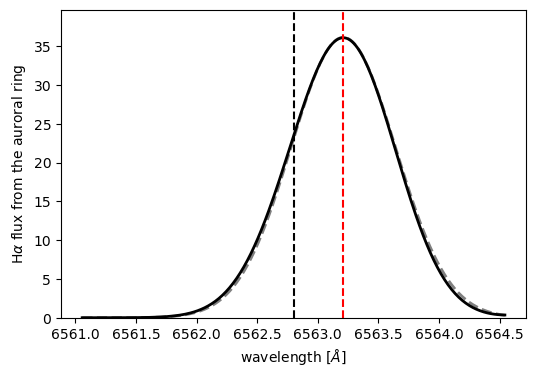

<Quantity 0.41034446>

In [157]:
start = 1.45

stop = start + 0.5
alphas = np.linspace(start*np.pi, stop*np.pi, 60)
spectra = [ring.get_flux_numerically(alpha=alpha, normalize=False, foreshortening=True) for alpha in alphas]
plt.figure(figsize=(6, 4))
wav = ring.v_mids * u.km/ u.s / c * 6562.8 + 6562.8
ddv = ring.v_mids[1]-ring.v_mids[0]
specs = []
for spectrum in spectra:
    # fold each spectrum with a gaussian of width 20 km/s
    dv = 17 * u.km / u.s  / ddv
    
    spectrum = gaussian_filter1d(spectrum, dv.value)
    specs.append(spectrum)
    # plt.plot(wav, spectrum)


# fit a gaussian to the spectrum
def gaussian(x, a, c):
    return a * np.exp(-(x - wav[np.argmax(spectrum)])**2 / (2 * c**2))

# sum and normalize the spectra
spectrum = np.sum(specs, axis=0)/np.max(specs)


popt, pcov = curve_fit(gaussian, wav.value, spectrum, p0=[1, 1])

plt.plot(wav, gaussian(wav.value, *popt), lw=2, color='grey', ls='--')

plt.plot(wav, spectrum, lw=2, color='k')
plt.xlabel(r'wavelength [$\AA$]')
plt.ylabel(r'H$\alpha$ flux from the auroral ring')

# vertical line at maximum of spectrum
plt.axvline(wav[np.argmax(spectrum)], color='r', ls='--')

# plt.xlim(6562-50, 6562+50)
plt.ylim(0,1.1*np.max(spectrum))
plt.axvline(6562.8, color='k', ls='--')
plt.show()

wav[np.argmax(spectrum)] - 6562.8


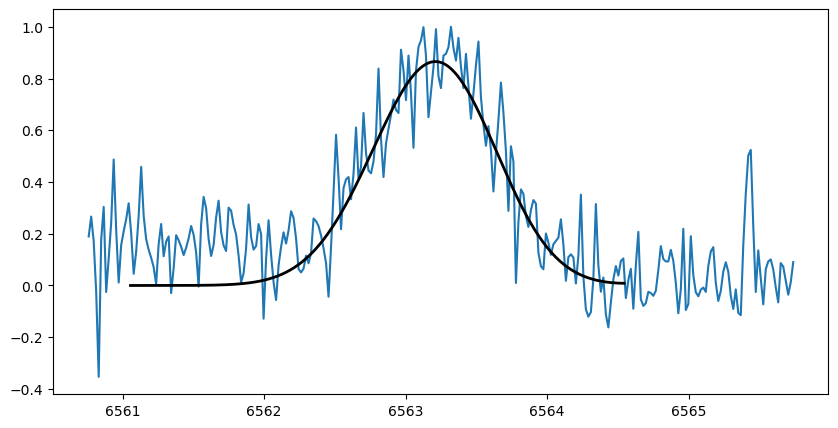

In [160]:
import glob
from astropy.io import fits


files = glob.glob('spectra/*RED_SCI_POINT*.fits')
# sort files by date
files.sort()
files = files[::-1]


rv = 11.6 * u.km/u.s
midwav = 6562.8 * u.AA
offset = (rv / c * midwav).to(u.AA).value

hdu = fits.open(files[3])[0]

x = np.array([hdu.header["CRVAL1"] + hdu.header["CDELT1"] * i for i in range(len(hdu.data))])

mask = (x > 6561) & (x < 6566)

x = x[mask]
y = hdu.data[mask] -80

# fit a gaussian to the data
from astropy.modeling import models, fitting
g_init = models.Gaussian1D(amplitude=80, mean=6563.2, stddev=0.1) 


fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x, y)

plt.figure(figsize=(10, 5))

plt.plot(x-offset, y/np.max(y))



# plt.plot(x-offset, g(x)/np.max(y), lw=2, color='grey', ls='--')

maxval = np.max(g(x)/np.max(y))

# return the FWHM of the gaussian
fwhm = 2 * np.sqrt(2 * np.log(2)) * g.stddev.value

fwhm, g.stddev.value
plt.plot(wav, spectrum/np.max(spectrum)*maxval, lw=2, color='k')

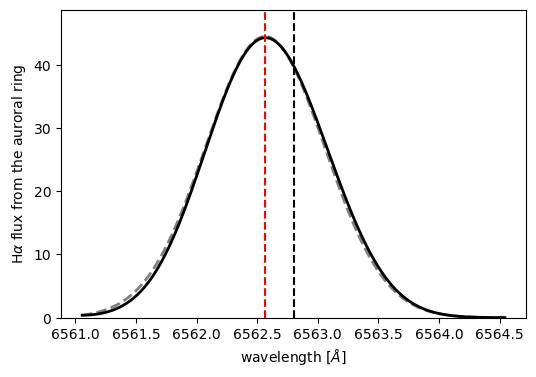

<Quantity -0.23448255>

In [152]:
alphas = np.linspace((start + .5)*np.pi, (stop + .5)*np.pi, 60)
spectra = [ring.get_flux_numerically(alpha=alpha, normalize=False, foreshortening=True) for alpha in alphas]
plt.figure(figsize=(6, 4))
wav = ring.v_mids * u.km/ u.s / c * 6562.8 + 6562.8
ddv = ring.v_mids[1]-ring.v_mids[0]
specs = []
for spectrum in spectra:
    # fold each spectrum with a gaussian of width 20 km/s
    dv = 18 * u.km / u.s  / ddv
    
    spectrum = gaussian_filter1d(spectrum, dv.value)

    specs.append(spectrum)
    # plt.plot(wav, spectrum)


# sum and normalize the spectra
spectrum = np.sum(specs, axis=0)/np.max(specs)
mm = np.max(specs)

popt, pcov = curve_fit(gaussian, wav, spectrum, p0=[1, 1])

plt.plot(wav, gaussian(wav, *popt), lw=2, color='grey', ls='--')

plt.plot(wav, spectrum, lw=2, color='k')
plt.xlabel(r'wavelength [$\AA$]')
plt.ylabel(r'H$\alpha$ flux from the auroral ring')

# vertical line at maximum of spectrum
plt.axvline(wav[np.argmax(spectrum)], color='r', ls='--')

# plt.xlim(6562-50, 6562+50)
plt.ylim(0,1.1*np.max(spectrum))
plt.axvline(6562.8, color='k', ls='--')
plt.show()

wav[np.argmax(spectrum)] - 6562.8


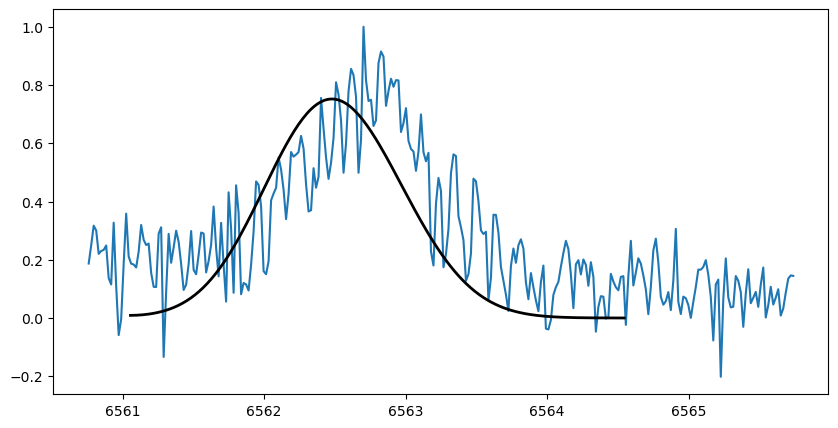

In [9]:
files = glob.glob('spectra/*RED_SCI_POINT*.fits')
# sort files by date
files.sort()
files = files[::-1]


rv = 11.6 * u.km/u.s
midwav = 6562.8 * u.AA
offset = (rv / c * midwav).to(u.AA).value

hdu = fits.open(files[4])[0]

x = np.array([hdu.header["CRVAL1"] + hdu.header["CDELT1"] * i for i in range(len(hdu.data))])

mask = (x > 6561) & (x < 6566)

x = x[mask]
y = hdu.data[mask] -80

# fit a gaussian to the data
from astropy.modeling import models, fitting
g_init = models.Gaussian1D(amplitude=80, mean=6563.2, stddev=0.1) 


fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x, y)

plt.figure(figsize=(10, 5))

plt.plot(x-offset, y/np.max(y))



# plt.plot(x-offset, g(x)/np.max(y), lw=2, color='grey', ls='--')

maxval = np.max(g(x)/np.max(y))

# return the FWHM of the gaussian
fwhm = 2 * np.sqrt(2 * np.log(2)) * g.stddev.value

fwhm, g.stddev.value
plt.plot(wav, spectrum/np.max(spectrum)*maxval*1.15, lw=2, color='k')

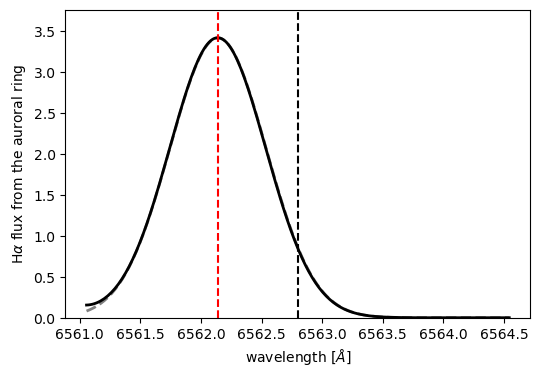

<Quantity -0.65948218>

In [465]:

alphas = np.linspace((start +1)*np.pi, (stop +1)*np.pi, 60)
spectra = [ring.get_flux_numerically(alpha=alpha, normalize=False, foreshortening=True) for alpha in alphas]
plt.figure(figsize=(6, 4))
wav = ring.v_mids * u.km/ u.s / c * 6562.8 + 6562.8
ddv = ring.v_mids[1]-ring.v_mids[0]
specs = []
for spectrum in spectra:
    # fold each spectrum with a gaussian of width 20 km/s
    dv = 18 * u.km / u.s  / ddv
    
    spectrum = gaussian_filter1d(spectrum, dv.value)
    specs.append(spectrum)
    # plt.plot(wav, spectrum)

# sum and normalize the spectra
spectrum = np.sum(specs, axis=0)/mm# np.max(specs)


popt, pcov = curve_fit(gaussian, wav.value, spectrum, p0=[1, 1])

plt.plot(wav, gaussian(wav.value, *popt), lw=2, color='grey', ls='--')

plt.plot(wav, spectrum, lw=2, color='k')
plt.xlabel(r'wavelength [$\AA$]')
plt.ylabel(r'H$\alpha$ flux from the auroral ring')

# vertical line at maximum of spectrum
plt.axvline(wav[np.argmax(spectrum)], color='r', ls='--')

# plt.xlim(6562-50, 6562+50)
plt.ylim(0,1.1*np.max(spectrum))
plt.axvline(6562.8, color='k', ls='--')
plt.show()

wav[np.argmax(spectrum)] - 6562.8


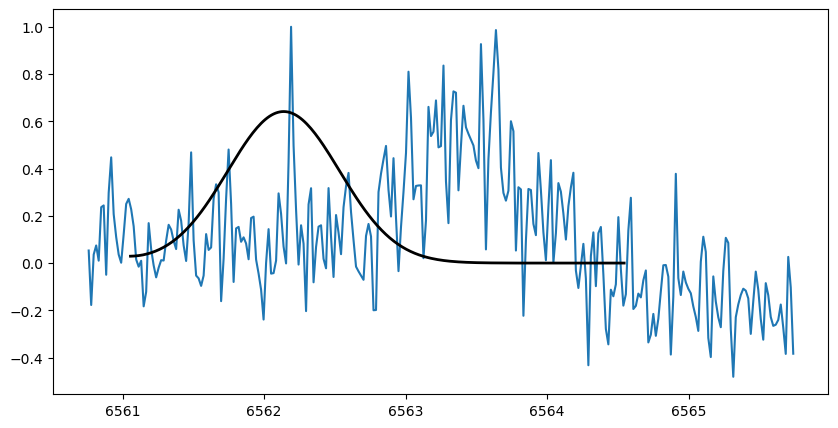

In [466]:
files = glob.glob('spectra/*RED_SCI_POINT*.fits')
# sort files by date
files.sort()
files = files[::-1]


rv = 11.6 * u.km/u.s
midwav = 6562.8 * u.AA
offset = (rv / c * midwav).to(u.AA).value

hdu = fits.open(files[-1])[0]

x = np.array([hdu.header["CRVAL1"] + hdu.header["CDELT1"] * i for i in range(len(hdu.data))])

mask = (x > 6561) & (x < 6566)

x = x[mask]
y = hdu.data[mask] -85

# fit a gaussian to the data
from astropy.modeling import models, fitting
g_init = models.Gaussian1D(amplitude=80, mean=6563.2, stddev=0.1) 


fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x, y)

plt.figure(figsize=(10, 5))

plt.plot(x-offset, y/np.max(y))



# plt.plot(x-offset, g(x)/np.max(y), lw=2, color='grey', ls='--')

maxval = np.max(g(x)/np.max(y))

# return the FWHM of the gaussian
fwhm = 2 * np.sqrt(2 * np.log(2)) * g.stddev.value

fwhm, g.stddev.value
plt.plot(wav, spectrum/np.max(spectrum)*maxval*1.15, lw=2, color='k')

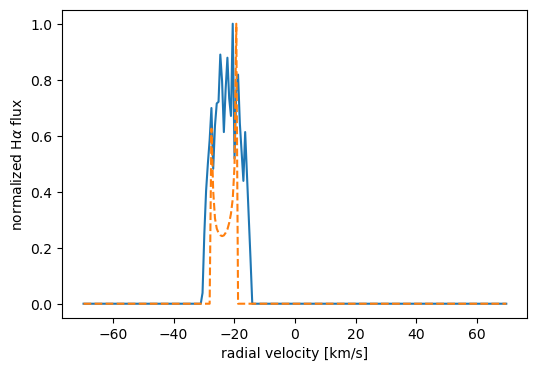

In [360]:
# plot an individual spectral line profile
plt.figure(figsize=(6, 4))

# rotational phase of the star in radians
alpha = np.pi / 4.

# get the numerical and analytical flux
flux_num = ring.get_flux_numerically(alpha=alpha, normalize=True, foreshortening=True)
flux_analytical = ring.get_flux_analytically(alpha=alpha, normalize=True, foreshortening=True)

# NOTE: the difference between the numerical and analytical fluxes is due to the fact that the numerical flux is
# calculated by summing the fluxes of all the grid cells, while the analytical flux is calculated by integrating
# the flux over the ring. The numerical flux is more accurate, but the analytical flux is faster to compute.
# The analytical solution assumes a infinitesimally thin ring, while the numerical solution uses a finite width ring.
# A thinner ring width will give a better agreement between the numerical and analytical fluxes.

# plot the fluxes
plt.plot(ring.v_mids, flux_num, label='numerical')
plt.plot(ring.v_mids, flux_analytical, label='analytical', ls='--')

plt.xlabel(r'radial velocity [km/s]')
plt.ylabel(r'normalized H$\alpha$ flux');